In [255]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import matplotlib.pyplot as plt

In [256]:
url = 'https://raw.githubusercontent.com/yasaswinik12/LSTM_datasets/main/tamil_offensive_full_train.csv?token=AOSGB3O2IJV56KFHUJVZ7W273SFGU'
train = pd.read_csv(url, delimiter='\t', names=['sentence','classes','nan'])
train = train.drop(columns=['nan'])
train.head()

,sentence,classes
0,movie vara level la Erika poguthu,Not_offensive
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil
2,Padam nalla comedy padama irukum polaye..,Not_offensive
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive


In [257]:
train.count()

sentence    35139
classes     35139
dtype: int64

In [258]:
train.describe()

,sentence,classes
count,35139,35139
unique,34883,6
top,neraya neraya neraya neraya neraya neraya.,Not_offensive
freq,7,25425


In [259]:
train['classes'].apply(len).max()

36

In [260]:
train['sentence'].apply(len).max()

1149

In [261]:
set(train['classes']) 

{'Not_offensive',
 'Offensive_Targeted_Insult_Group',
 'Offensive_Targeted_Insult_Individual',
 'Offensive_Targeted_Insult_Other',
 'Offensive_Untargetede',
 'not-Tamil'}

In [262]:
encode_dict = {}

def encode_cat(x):
  if x not in encode_dict.keys():
    encode_dict[x] = len(encode_dict)
  return encode_dict[x]

train['encode_cat'] = train['classes'].apply(lambda x: encode_cat(x))
train['encode_cat'].value_counts()

0    25425
4     2906
3     2557
5     2343
1     1454
2      454
Name: encode_cat, dtype: int64

In [269]:
train.head(9)

,sentence,classes,encode_cat
0,movie vara level la erika poguthu,Not_offensive,0
1,i love ajith kumar vivegam movie inki mjy bht ...,not-Tamil,1
2,padam nalla comedy padama irukum polaye..,Not_offensive,0
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive,0
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive,0
5,ippo intha trailer ah parkuravana oru like pod...,Not_offensive,0
6,en thalaivan yogi babu irukkaar. padam vera le...,Not_offensive,0
7,nerkonda parvai... sema sema sema trailer,Not_offensive,0
8,ஏய் இது யார் ஏமாத்தறீங்க? செம பின்னிட்டீங்க,Not_offensive,0


In [270]:
import imblearn
print(imblearn.__version__)

0.4.3


In [271]:
from collections import Counter

Class=0, n=25425 (72.356%)
Class=1, n=1454 (4.138%)
Class=2, n=454 (1.292%)
Class=3, n=2557 (7.277%)
Class=4, n=2906 (8.270%)
Class=5, n=2343 (6.668%)


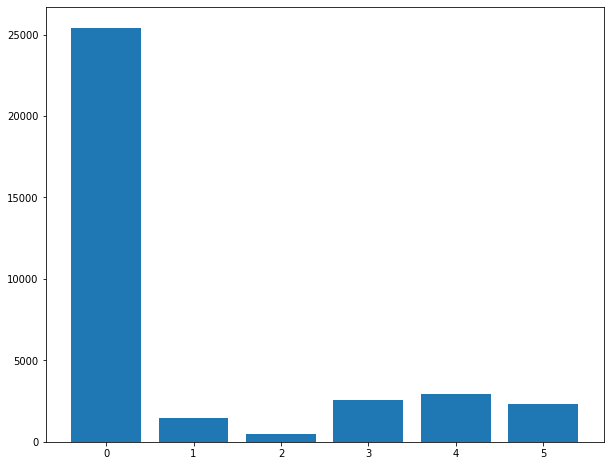

In [272]:
from matplotlib import pyplot
X = train['sentence']
y = train['encode_cat']
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [273]:
train['sentence'] = train['sentence'].apply(lambda x: x.lower())
train['sentence'] = train['sentence'].apply(lambda x: re.sub(r' +', ' ',x))
train['sentence'] = train['sentence'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
train['sentence'] = train['sentence'].str.replace('\d+', '')

max_features = 2000
max_len = 512
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train['sentence'].values)
X = tokenizer.texts_to_sequences(train['sentence'].values)
# vocab_size = len(tokenizer.word_index) + 1
X = pad_sequences(X,padding = 'post', maxlen=max_len)

In [274]:
train['sentence'].apply(len).max()

1124

In [275]:
train.describe()

,encode_cat
count,35139.000000
mean,0.949714
std,1.684117
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,5.000000


In [276]:
Y = pd.get_dummies(y).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(28111, 512) (28111, 6)
(7028, 512) (7028, 6)


In [277]:
from keras.layers import Layer
from keras.layers import Input
from keras.models import Model
from tensorflow.keras import backend as K

class attention(Layer):
    def __init__(self):
        super(attention,self).__init__()

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [45]:
# !wget --header="Host: nlp.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.456156586.1539718115; _gid=GA1.2.491677602.1539718115; _gat=1" --header="Connection: keep-alive" "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" -c

In [29]:
# !unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [278]:
 from numpy import array
 from numpy import asarray
 from numpy import zeros

 embeddings_index = dict()

 glove_file = open('glove.6B.100d.txt', encoding="utf8")

 for line in glove_file:
     records = line.split()
     word = records[0]
     vector_dimensions = asarray(records[1:], dtype='float32')
     embeddings_index[word] = vector_dimensions
 glove_file.close()

 print('Found %s word vectors.' %len(embeddings_index))

 

Found 400000 word vectors.


In [279]:
word_index = tokenizer.word_index
print(len(word_index))


num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

66596
2001


In [280]:
K.clear_session()
from keras.regularizers import l2
from keras.initializers import Constant
embed_dim = 100
lstm_out = 128
# model = Sequential()
inputs = Input(shape=(512,))
x = Embedding(num_words, embed_dim,embeddings_initializer=Constant(embedding_matrix),input_length = X_train.shape[1])(inputs)
att_in = Bidirectional(LSTM(lstm_out,return_sequences=True, dropout=0.2))(x)
att_out = attention()(att_in)
d = Dropout(0.2)(att_out)
outputs = Dense(6, activation='softmax')(d)
model = Model(inputs,outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          200100    
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 256)          234496    
_________________________________________________________________
attention (attention)        (None, 256)               768       
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 436,906
Trainable params: 436,906
Non-trainable params: 0
_______________________________________________________

In [281]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [282]:
history = model.fit(X_train, Y_train,batch_size = 128, validation_data=(X_test,Y_test), epochs=10, verbose=2)

Epoch 1/10
220/220 - 26s - loss: 0.9845 - accuracy: 0.7222 - val_loss: 0.9112 - val_accuracy: 0.7218
Epoch 2/10
220/220 - 23s - loss: 0.8687 - accuracy: 0.7325 - val_loss: 0.8199 - val_accuracy: 0.7410
Epoch 3/10
220/220 - 23s - loss: 0.7846 - accuracy: 0.7505 - val_loss: 0.7871 - val_accuracy: 0.7462
Epoch 4/10
220/220 - 23s - loss: 0.7464 - accuracy: 0.7560 - val_loss: 0.7709 - val_accuracy: 0.7490
Epoch 5/10
220/220 - 23s - loss: 0.7253 - accuracy: 0.7609 - val_loss: 0.7634 - val_accuracy: 0.7486
Epoch 6/10
220/220 - 23s - loss: 0.8920 - accuracy: 0.7215 - val_loss: 0.8163 - val_accuracy: 0.7302
Epoch 7/10
220/220 - 23s - loss: 0.7479 - accuracy: 0.7549 - val_loss: 0.7719 - val_accuracy: 0.7500
Epoch 8/10
220/220 - 23s - loss: 0.7063 - accuracy: 0.7679 - val_loss: 0.7527 - val_accuracy: 0.7533
Epoch 9/10
220/220 - 23s - loss: 0.6884 - accuracy: 0.7700 - val_loss: 0.7584 - val_accuracy: 0.7513
Epoch 10/10
220/220 - 23s - loss: 0.6743 - accuracy: 0.7743 - val_loss: 0.7473 - val_accura

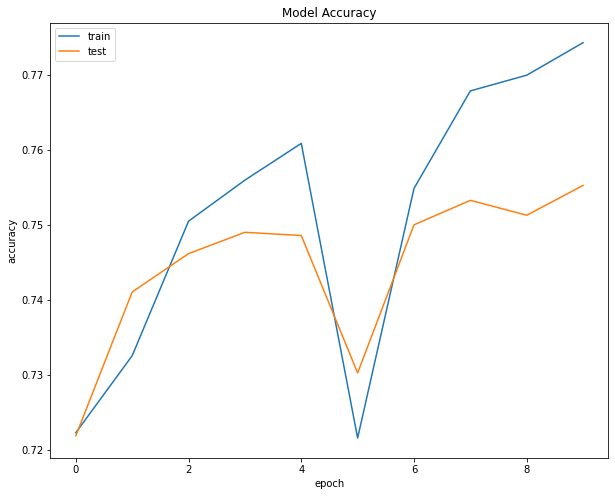

In [283]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
#plt.show()
plt.savefig('Model_accuracy.png', dpi=600)

In [284]:
score = model.evaluate(X_test,Y_test,verbose=1)
predictions = np.argmax(model.predict(X_test),axis = -1)

print("Test score is {}".format(score[0]))
print("Test Accuracy is {}".format(score[1]))

220/220 [==============================] - 4s 19ms/step - loss: 0.7473 - accuracy: 0.7553
Test score is 0.7472585439682007
Test Accuracy is 0.7552646398544312


In [285]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)

In [286]:
rounded_predictions = np.argmax(model.predict(X_test, batch_size=128, verbose=0),axis = -1)

In [287]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)

In [288]:
from sklearn.metrics import classification_report

In [289]:
print(classification_report(rounded_labels, rounded_predictions))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      5064
           1       0.75      0.61      0.68       259
           2       0.00      0.00      0.00       100
           3       0.39      0.11      0.17       520
           4       0.41      0.27      0.33       608
           5       0.41      0.12      0.18       477

    accuracy                           0.76      7028
   macro avg       0.46      0.35      0.37      7028
weighted avg       0.69      0.76      0.71      7028



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
